# High-dimensional regression for change-points

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp

Consider the following function, and a simulated dataset obtained by adding noise to it.

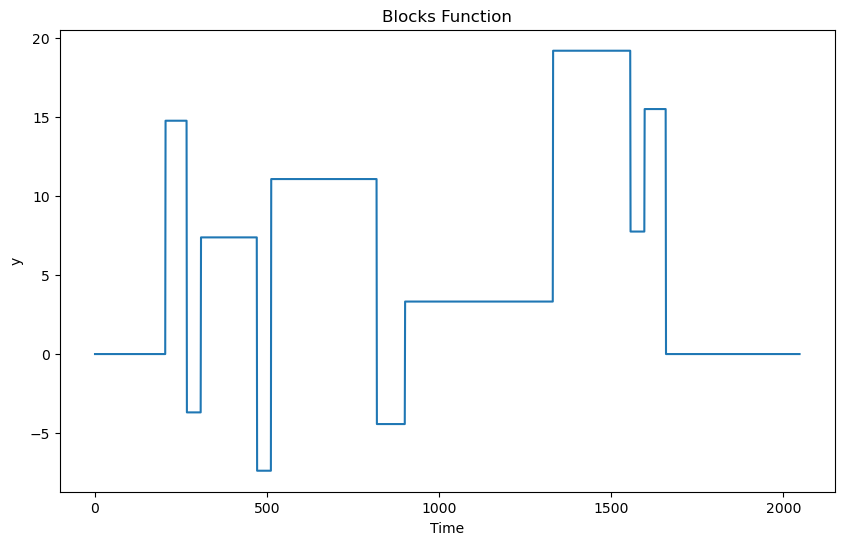

In [5]:
def blocks(x):
    """
    Convert the R arblocks function to Python using NumPy
    """
    # Create the step function using array operations
    ans = 4 * np.asarray(x > 0.1, dtype = float) 
    ans -= 5 * np.asarray(x > 0.13, dtype = float)
    ans += 3 * np.asarray(x > 0.15, dtype = float)
    ans -= 4 * np.asarray(x > 0.23, dtype = float)
    ans += 5 * np.asarray(x > 0.25, dtype = float)
    ans -= 4.2 * np.asarray(x > 0.40, dtype = float)
    ans += 2.1 * np.asarray(x > 0.44, dtype = float)
    ans += 4.3 * np.asarray(x > 0.65, dtype = float)
    ans -= 3.1 * np.asarray(x > 0.76, dtype = float)
    ans += 2.1 * np.asarray(x > 0.78, dtype = float)
    ans -= 4.2 * np.asarray(x > 0.81, dtype = float)
    
    # Apply scaling
    ans = ans * 7 * 1.3 / np.sqrt(6.0695)
    
    return ans

# Create sequence similar to R's seq
n = 2048
xps = np.linspace(0, 1, n)

# Generate the function values
truth = blocks(xps)

# Create plot similar to R's plot with type="l" (line)
plt.figure(figsize = (10, 6))
plt.plot(truth)
plt.title("Blocks Function")
plt.xlabel("Time")
plt.ylabel("y")
plt.show()

In [6]:
sig = 5
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sig, size = n)
y = truth + errorsamples

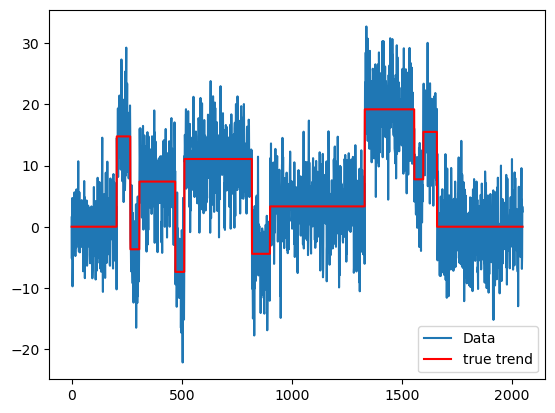

In [7]:
plt.plot(y, label = 'Data')
plt.plot(truth, label = 'true trend', color = 'red')
plt.legend()
plt.show()

We will use the following model for this dataset: 
\begin{equation*}
    y_t = \beta_0 + \beta_1 I\{t \geq 2 \} + \beta_2 I\{t \geq 3 \} + \dots + \beta_{n-1} I\{t \ge n \} + \epsilon_t
\end{equation*}
This model is slightly different from the one used in class. It has indicators instead of ReLUs. This model is more appropriate in this problem because of the change point structure. 

This model can be written as $y = X \beta + \epsilon$ where
\begin{equation*}
   X = \begin{pmatrix} 1 & 0 & 0 & \cdot & \cdot & \cdot & 0 \\
   1 & 1 & 0 & \cdot & \cdot & \cdot & 0 \\
   1 & 1 & 1 & \cdot & \cdot & \cdot & 0 \\
   \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
   \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
   \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
   1 & 1 & 1 & \cdot & \cdot & \cdot & 1
    \end{pmatrix}
\end{equation*}

In [8]:
# It is very easy to create the above matrix in python:
X = np.tril(np.ones((n, n)), k = 0)

Derive that the unregularized estimate of $\beta$ is given by: 
\begin{equation*}
   \hat{\beta}_0 = y_1 ~~~\text{ and }~~~ \hat{\beta}_t = y_{t+1} - y_t
\end{equation*}
for $t = 1, 2, \dots, n-1$. This can be verified as follows. 

In [9]:
unreg_md = sm.OLS(y, X).fit()
print(unreg_md.params)
print(np.diff(y))
print(y[0])

[ 1.5235854  -6.72350593  8.95217651 ...  1.92407071  8.27388838
 -0.81259816]
[-6.72350593  8.95217651  0.9505676  ...  1.92407071  8.27388838
 -0.81259816]
1.5235853987721568


Let us now see the performance of the regularized estimators. The ridge estimator minimizes: 
\begin{equation*}
   \sum_{t=1}^n \left(y_t -  \beta_0 - \beta_1 I\{t \geq 2 \} - \beta_2 I\{t \geq 3 \} - \dots - \beta_{n-1} I\{t \ge n \}\right)^2 + \lambda \sum_{t=1}^{n-1} \beta_t^2 
\end{equation*}
and the LASSO estimator minimizes
\begin{equation*}
   \sum_{t=1}^n \left(y_t -  \beta_0 - \beta_1 I\{t \geq 2 \} - \beta_2 I\{t \geq 3 \} - \dots - \beta_{n-1} I\{t \ge n \}\right)^2 + \lambda \sum_{t=1}^{n-1} |\beta_t|
\end{equation*}

We use the following functions (from class) to compute the ridge and lasso estimators. 

In [10]:
# note that penalty_start is now set to 1 (instead of 2 as in the model used in class)
def solve_ridge(X, y, lambda_val, penalty_start = 1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [11]:
# note that penalty_start is now set to 1 (instead of 2 as in the model used in class)
def solve_lasso(X, y, lambda_val, penalty_start = 1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

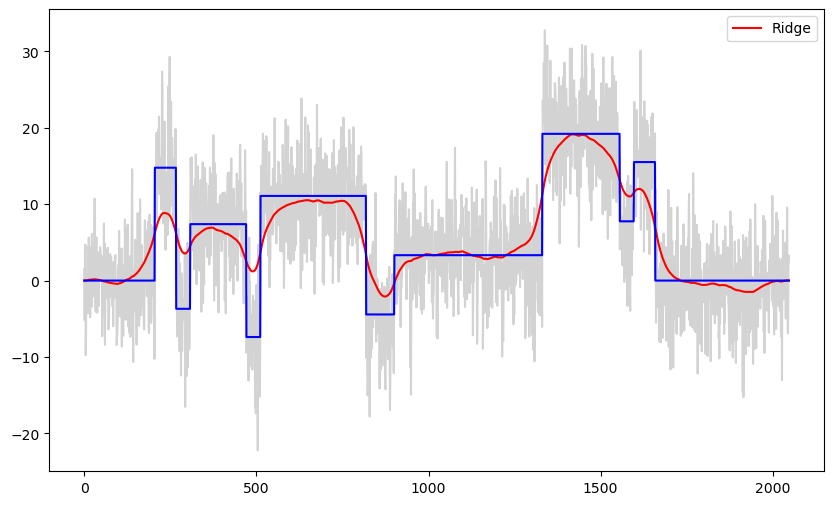

In [12]:
# Start from lambda_val = 1 and increase or decrease it by factors of 10 until we get a fit that is visually satisfactory
b_ridge = solve_ridge(X, y, lambda_val = 1000)
ridge_fitted = np.dot(X, b_ridge)

plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

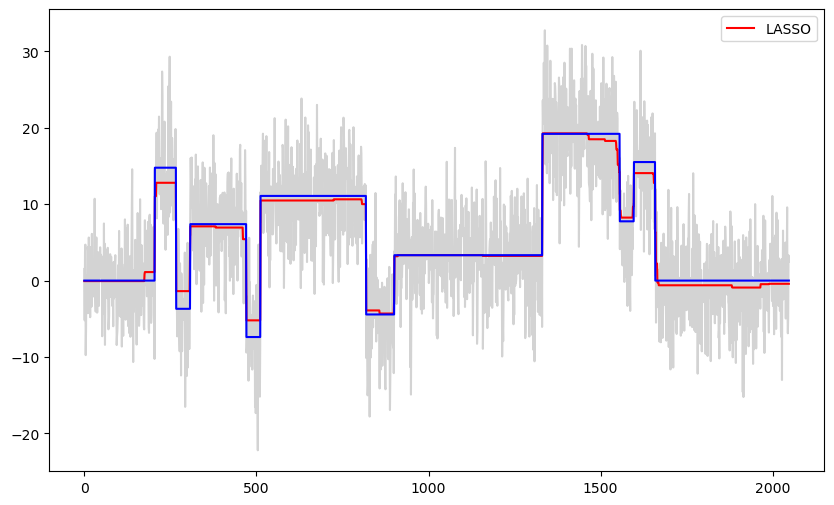

In [13]:
b_lasso = solve_lasso(X, y, lambda_val = 100)
lasso_fitted = np.dot(X, b_lasso)

plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

The LASSO fit is piecewise constant while the ridge fit is smoother (unless $\lambda$ is too small). Since the true function is also piecewise constant, LASSO gives better estimates in this problem compared to ridge regression. 

Let us now use 5-fold cross validation as in class to pick the tuning parameter $\lambda$. 

In [14]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [15]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = ridge_cv(X, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
10.0
CV errors for each lambda:
Lambda = 0.10, CV Error = 35.016886
Lambda = 1.00, CV Error = 30.595315
Lambda = 10.00, CV Error = 28.126842
Lambda = 100.00, CV Error = 29.269337
Lambda = 1000.00, CV Error = 36.342592
Lambda = 10000.00, CV Error = 48.464228
Lambda = 100000.00, CV Error = 66.791586


The best $\lambda$ given by CV for ridge is 10. This value is small enough for the method to pick up the jumps well. But unfortunately the estimate will be too wiggly in the constant parts. 

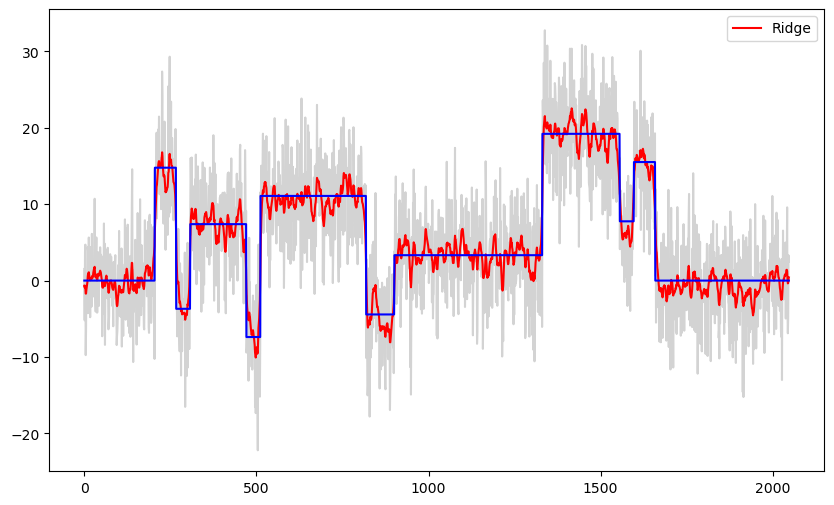

In [16]:
b_ridge = solve_ridge(X, y, lambda_val = 10)
ridge_fitted = np.dot(X, b_ridge)

plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

In [17]:
def lasso_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_lasso(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors) 
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [18]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = lasso_cv(X, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
100.0
CV errors for each lambda:
Lambda = 0.10, CV Error = 36.683225
Lambda = 1.00, CV Error = 35.473742
Lambda = 10.00, CV Error = 29.134453
Lambda = 100.00, CV Error = 27.146439
Lambda = 1000.00, CV Error = 45.607291
Lambda = 10000.00, CV Error = 76.963133
Lambda = 100000.00, CV Error = 76.963133


The best $\lambda$ chosen by cross validation is 100; which seems a good choice for this dataset. 

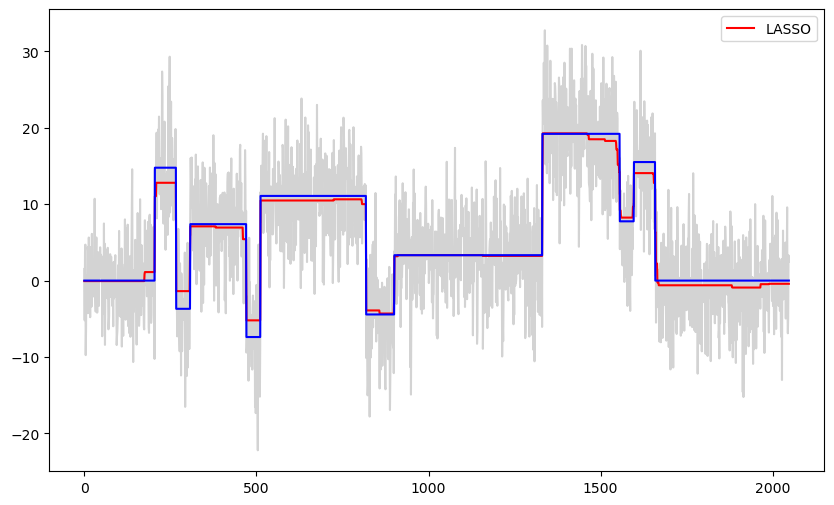

In [19]:
b_lasso = solve_lasso(X, y, lambda_val = 100)
lasso_fitted = np.dot(X, b_lasso)

plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

What happens when we try the same model (with ReLU functions) as in class for this dataset? 

In [20]:
n = len(y)
x = np.arange(1, n + 1)
Xfull = np.column_stack([np.ones(n), x - 1])
for i in range(n - 2):
    c = i + 2
    xc = ((x > c).astype(float)) * (x - c)
    Xfull = np.column_stack([Xfull, xc])

print(Xfull)

[[ 1.000e+00  0.000e+00 -0.000e+00 ... -0.000e+00 -0.000e+00 -0.000e+00]
 [ 1.000e+00  1.000e+00  0.000e+00 ... -0.000e+00 -0.000e+00 -0.000e+00]
 [ 1.000e+00  2.000e+00  1.000e+00 ... -0.000e+00 -0.000e+00 -0.000e+00]
 ...
 [ 1.000e+00  2.045e+03  2.044e+03 ...  1.000e+00  0.000e+00 -0.000e+00]
 [ 1.000e+00  2.046e+03  2.045e+03 ...  2.000e+00  1.000e+00  0.000e+00]
 [ 1.000e+00  2.047e+03  2.046e+03 ...  3.000e+00  2.000e+00  1.000e+00]]


Let us try the LASSO estimator. 

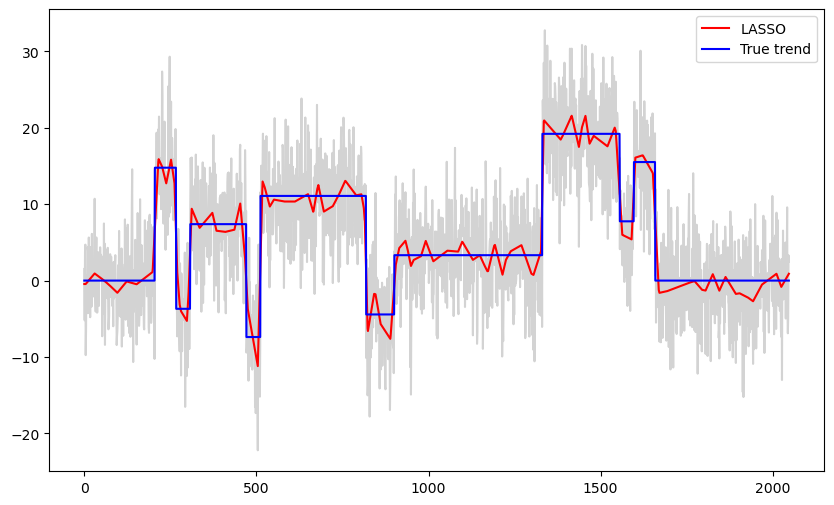

In [21]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 100)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, label = 'True trend', color = 'blue')
plt.legend()
plt.show()

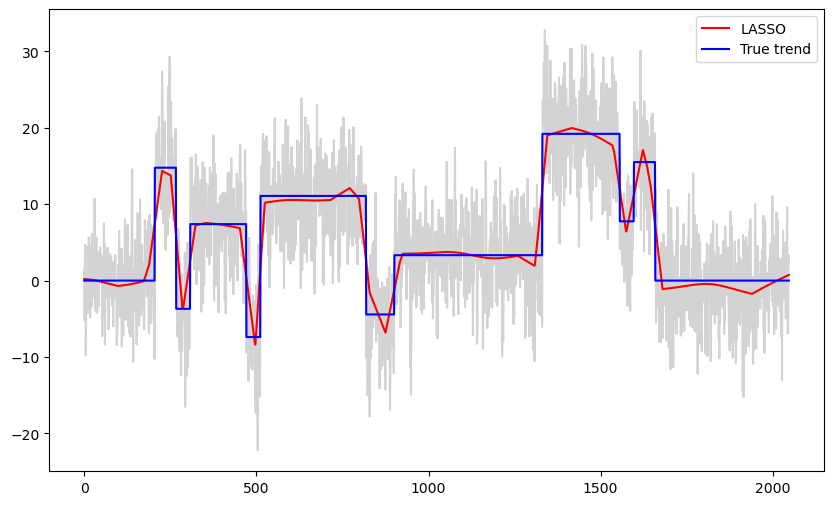

In [22]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 1000)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, label = 'True trend', color = 'blue')
plt.legend()
plt.show()

When $\lambda$ is small, this estimator will be too wiggly in the constant parts. On the other hand, when $\lambda$ is large, it will not be able to sharply detect the jumps.